### Analysis and plotting

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

%matplotlib inline

In [8]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
## Open data files

---
---
#### Open our merged GOES-CUES dataset

In [9]:
cues_ds = pd.read_pickle('goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()

In [10]:
#df = pd.read_pickle('goes-cues-2017-2020-6hr.pkl')


Load MODIS observations of the CUES site

In [11]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)

When do we have ASTER observations of this site?

In [12]:
# Find all our ASTER files for the CUES site
directory1 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_Tuolumne_only/'
directory2 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_both/'

aster_files = getListOfFiles(directory1) + getListOfFiles(directory2)

## Parse the date and time from ASTER filenames
aster_datetimes = []
for fpath in aster_files:
    #fn = re.split('\/+|\\+',fpath)[-1] # re method
    fn = fpath.split('/')[-1] # non-re method
    MM = fn.split('_')[2][3:5]
    DD = fn.split('_')[2][5:7]
    YYYY = fn.split('_')[2][7:11]
    hh = fn.split('_')[2][11:13]
    mm = fn.split('_')[2][13:15]
    ss = fn.split('_')[2][15:17]
    aster_datetimes.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss)) - pd.Timedelta(hours=7))

aster = pd.DataFrame({'datetime': aster_datetimes, 'filepath': aster_files})
aster.sort_values('datetime',inplace=True)
aster.reset_index(inplace=True, drop=True)

Set font sizes for plots

In [13]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [14]:
def plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color='k', heatmap_cmap=None):
    _x = _x.sel(datetime=slice(startdate, enddate))
    _y = _y.sel(datetime=slice(startdate, enddate))

    # Linear regression between x and y
    x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar = quickstats(_x, _y)
    fit = slope*x + intercept
    # Compute some more stats between x and y:
    #print('r-squared = {}'.format(np.round(r_value**2,2)))

    
    plt.figure(figsize=(5.5,5.5))
    # Plot gridlines
    plt.grid(color='grey', linestyle=':', linewidth=1)
    # Plot points and best linear fit
    #plt.plot(x, fit, ':r', zorder=99)

    if heatmap_cmap == None:
        plt.plot(x,y,'.',color=point_color,markersize=5,alpha=0.5)
    else:
        # Create 2d histogram "heatmap"
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        # Plot "heatmap"
        plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=heatmap_cmap)
        plt.colorbar(label='number of records')

    # Plot 1-to-1 line
    plt.plot([-30,30],[-30,30],':k')

    # Set axes limits
    plt.xlim([-30,30])
    plt.ylim([-30,30])

    # Set axes labels, plot title
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title('{} -- {}\n$RMSE$ = {}, mean bias = {}'.format(startdate,enddate,
                                                            np.round(rmse,2),
                                                           np.round(mbe,2)))
    plt.tight_layout()
    
    return None

def quickstats(_x,_y):
    # remove nan values from input _x and _y before linear regression
    df1 = pd.DataFrame({'x': _x})
    df1['y'] = _y
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Linear regression between x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean(np.square(y - x)))
    
    # Mean Bias Error
    mbe = np.mean(y - x)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(y - x))
    
    # Covariance
    X = np.stack((x, y), axis=0)
    covar = np.cov(X)
    
    return x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar

In [15]:
from datetime import timedelta, datetime

def datetimerange(start_date, end_date, n_hours):
    # https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python/1060330#1060330
    # for every hour in this date range
    for n in range(int ( (end_date - start_date).total_seconds() / 3600 )):
        # if we've moved n_hours
        if n % n_hours == 0:
            # return the start date + that many hours we've stepped forward
            yield start_date + timedelta(hours=n)

## For comparison with ASTER, looking at single days

#### Create 1-to-1 plots to take a look at the slope of the regression lines in more detail for days with ASTER observations

In [16]:
#aster

2020-01-10 00:00:00
2020-01-10 06:00:00
2020-01-10 12:00:00
2020-01-10 18:00:00


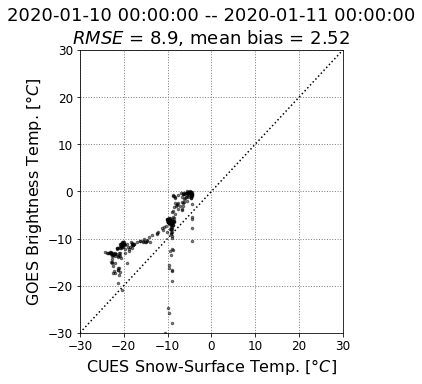

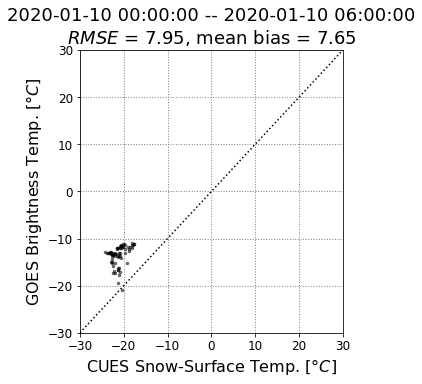

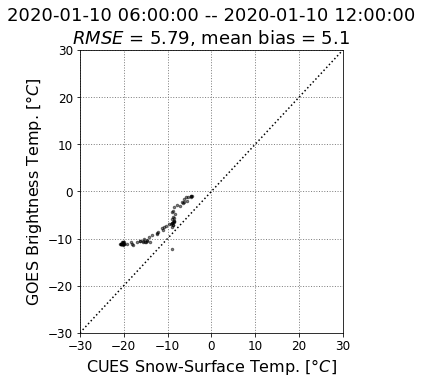

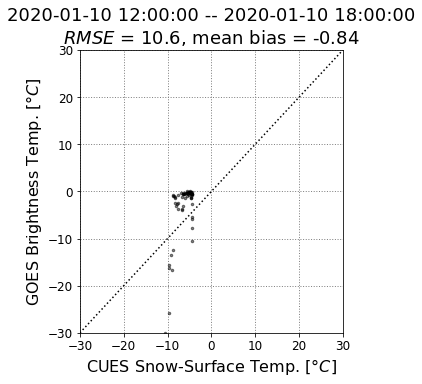

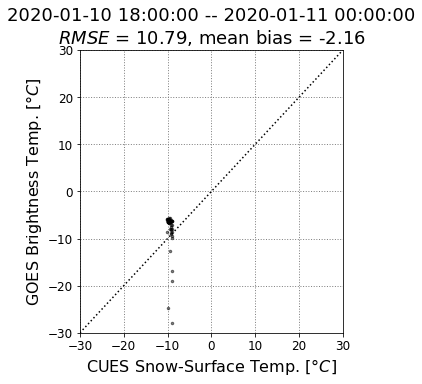

In [17]:
start_date = datetime(2020, 1, 10)
end_date = datetime(2020, 1, 11)
n_hours = 6

_x = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(cues_ds.cloud_flag==0)
x_label = 'CUES Snow-Surface Temp. [$\degree C$]'

_y = cues_ds.goes_tb_c.where(cues_ds.cloud_flag==0)
y_label = 'GOES Brightness Temp. [$\degree C$]'

# plot whole day
plot1to1(_x, _y, x_label, y_label, start_date, end_date, point_color='k', heatmap_cmap=None)

for single_datetime in datetimerange(start_date, end_date, n_hours=n_hours):
    print(single_datetime.strftime("%Y-%m-%d %H:%M:%S"))

    startdate = single_datetime
    enddate = single_datetime + timedelta(hours=n_hours)
    
    plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color='k', heatmap_cmap=None)

In [ ]:
#plt.figure(figsize=(8,8))
#plt.plot(df.mbe,df.rmse,'k.')
#plt.xlabel('Mean Bias')
#plt.ylabel('RMSE')
##plt.xlim(-40,40)
##plt.ylim(-1.5,1.5)
#plt.title('6-hr Mean Bias vs Daily RMSE\nwhen snow is present\nfrom {} to {}'.format(startdate,enddate))
#plt.tight_layout()

In [ ]:
#binwidth = 2
#
#for year_month in df.groupby(df.index.to_period('M')).mean().index:
#    this_month = df.loc[df.index.to_period('M') == year_month]
#    
#    plt.figure(figsize=(4,4))
#    N, bins, _ = plt.hist(this_month.rmse,bins=range(0, 50+binwidth, binwidth))
#    plt.xlim(0,50)
#    plt.ylim(0,50)
#    plt.title('6-hr RMSE when snow is present\nfor {}'.format(year_month))
#    try:
#        maxima_indices = argrelmax(N, order=1)[0]
#        largest_mode = bins[:-1][N==N[maxima_indices].max()].mean()
#        plt.axvline(x=largest_mode+(binwidth/2),linestyle=':',color='k')
#    except (IndexError, ValueError):
#        pass
#    plt.xlabel('RMSE')
#    plt.ylabel('Number of 6-hour periods')
#    plt.tight_layout()